In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from Base import *

In [2]:
##-----Constants-----##
MASSTIMECOEFF = 0.03
MAXWEIGHT = 100
YEAR = 2018
FILE_NAME = '2021 Season.xlsx'
FASTEST_TEAM = 'Mercedes'

##-----Lists & Dictionaries-----##
event_dict = {}
baseline_dict = {}
event_list = []

##-----Dataframes-----##
fullregression_df = pd.DataFrame(
    columns=['Driver', 'Stint', 'Compound', 'Slope', 'Intercept', 'R Value', 'Standard Error', 'No of Laps',
             'Laps Till End', 'Team', 'Grand Prix'])
regression_df = pd.DataFrame(
    columns=['Compound', 'Slope', 'Intercept', 'R Value', 'Standard Error', 'No of Laps', 'Laps Till End', 'Team',
             'Average Lap Time'])
avgdeg_df = pd.DataFrame(
    columns=['Team', 'Compound', 'Average Degradation', 'No of Laps', 'Average Lap Time'])
eventdeg_df = pd.DataFrame(
    columns=['Team', 'Event', 'Event Number', 'Average Degradation', 'No of Laps', 'Average Lap Time'])
ranking_df = pd.DataFrame(columns=['Team', 'Event', 'Event Number', 'Degradation Rank', 'Lap Time Rank'])
rankingchange_df = pd.DataFrame(columns=['Degradation Change', 'Lap Time Change'])
difference_df = pd.DataFrame(columns=['Team', 'Event', 'Event Number', 'Delta Degradation', 'Delta Laptime'])
differencechange_df = pd.DataFrame(columns=['Degradation Change', 'Lap Time Change'])

##-----Variables-----##
number = 1
lap_time_value = 0
new_value = 0
std_error_dev = 0
std_error_mean = 0
std_error_min = 0
std_error_max = 0
slope_dev = 0
slope_mean = 0
slope_min = 0
slope_max = 0
no_of_laps = 0
laps_till_end = 0
team = ''
compound = ''
avg_laptime = 0
slope = 0
intercept = 0
r_value = 0
p_value = 0
std_err = 0
avg_deg = 0
compound_laps = 0
delta_laptime = 0
deg_slope = 0
time_slope = 0
event_number = 0
min_deg = 0
min_lap = 0
delta_deg = 0


##-----Functions-----##
def getLaps(fyear, fevent):
    session = ff1.get_event(fyear, fevent).get_race()
    session.load()
    laps = session.laps
    return laps


def groupLaps(fdataframe, fname):
    groupedDataframe = fdataframe.groupby(fname)
    return groupedDataframe


def baseLapTime(fdataframe):
    dict = {}

    baseline_df = fdataframe[fdataframe['Team'] == FASTEST_TEAM]  #Filter dataframe so that only Red Bull Racing is used
    groupedDataframe = groupLaps(baseline_df, 'Compound')  #Group baseline_df by the Compound

    for compound_name, compound_df in groupedDataframe:
        dict[compound_name] = compound_df[
            'Average Lap Time'].mean()  #For each compound calculate the mean lap time and save it to a dictionary

    return dict


##-----Get Event List-----##
event_list = ff1.get_event_schedule(YEAR, include_testing=False)[['EventName', 'RoundNumber']]
event_dict = event_list.set_index('EventName').to_dict()[
    'RoundNumber']  #Creates a dictionary which can reference the Event Name vs the Round Number
event_list = ff1.get_event_schedule(YEAR, include_testing=False)['EventName'].to_list()

In [32]:
for event in event_list:
    ##Load & Initalise laps for each event##
    session = ff1.get_event(YEAR, event).get_race()
    session.load()
    laps = session.laps
    weather_data = session.laps.get_weather_data()
    laps = laps.reset_index(drop=True)
    weather_data = weather_data.reset_index(drop=True)

    # exclude the 'Time' column from weather data when joining
    laps = pd.concat([laps, weather_data.loc[:, ~(weather_data.columns == 'Time')]], axis=1)

    laps['Time'] = laps['Time'].dt.total_seconds()
    laps['LapTime'] = laps['LapTime'].dt.total_seconds()
    laps['PitOutTime'] = laps['PitOutTime'].dt.total_seconds()
    laps['PitInTime'] = laps['PitInTime'].dt.total_seconds()
    laps['Sector1Time'] = laps['Sector1Time'].dt.total_seconds()
    laps['Sector2Time'] = laps['Sector2Time'].dt.total_seconds()
    laps['Sector3Time'] = laps['Sector3Time'].dt.total_seconds()
    laps['Sector1SessionTime'] = laps['Sector1SessionTime'].dt.total_seconds()
    laps['Sector2SessionTime'] = laps['Sector2SessionTime'].dt.total_seconds()
    laps['Sector3SessionTime'] = laps['Sector3SessionTime'].dt.total_seconds()
    laps['LapStartTime'] = laps['LapStartTime'].dt.total_seconds()
    laps = laps.filter(['Time', 'DriverNumber', 'LapTime', 'LapNumber', 'PitOutTime',
                        'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
                        'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
                        'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
                        'Compound', 'TyreLife', 'FreshTyre', 'Stint', 'LapStartTime', 'Team',
                        'Driver', 'TrackStatus', 'IsAccurate', 'Rainfall'])

    groupedLap = groupLaps(laps, 'LapNumber')
    temp_df = pd.DataFrame()
    time = 0

    for lap_number, lap_df in groupedLap:
        number = 0
        lap_df['Position'] = lap_df['Time'].rank()
        lap_df = lap_df.sort_values(by='Position')

        lap_df['TimetoAhead'] = pd.Series([float('nan')] * len(lap_df))
        lap_df['TimetoBehind'] = pd.Series([float('nan')] * len(lap_df))

        for row in lap_df.itertuples():
            n = row.Index
            if number != 0:
                ahead = row.Time - time
                if ahead < 0:
                    print('')
                lap_df.at[prevn, 'TimetoBehind'] = ahead
                lap_df.at[n, 'TimetoAhead'] = (ahead * -1)

            number += 1
            time = row.Time
            prevn = row.Index
        temp_df = pd.concat([temp_df, lap_df], ignore_index=True, axis=0)
    laps = temp_df
    laps.to_pickle(f'{event} Full.pkl')

core           INFO 	Loading data for Australian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	No cached data found for position_data. Loading data...
api            INFO 	Fetching position data...
core        WARNING 	Failed to load telemetry data!
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['5', '44', '7', '3', '14', '33', '27', '77', '2', '55', '11', '31', '16', '18', '28', '8', '20', '10', '9', '35']
core           INFO 	Loading data for Bahrain Grand Prix - Ra

In [33]:
for event in event_list:
    laps = pd.read_pickle(f'{event} Full.pkl')
    max_laps = laps['LapNumber'].max()

    for row in laps.itertuples(index = True):
        index = row.Index
        lap = row.LapNumber
        lap_time_value = row.LapTime

        F = 100 / max_laps

        ##Change in time per lap times the number of laps passed##
        new_value = lap_time_value - (lap_time_value * (100 - lap * F) / 798)

        laps.at[index, 'FuelAdjustedLapTime'] = new_value #Assign new value
    laps = laps.pick_accurate().pick_track_status('1').loc[laps['Rainfall'] == False].pick_wo_box()
    laps = pd.DataFrame(laps)
    laps = laps.filter(['DriverNumber', 'FuelAdjustedLapTime', 'LapNumber', 'Compound', 'TyreLife', 'FreshTyre', 'Stint', 'LapStartTime', 'Team', 'Driver', 'Position', 'TimetoAhead', 'TimetoBehind'])
    laps.to_pickle(f'{event} Filtered.pkl')

In [3]:
event_list = ['Bahrain Grand Prix', 'Emilia Romagna Grand Prix', 'Portuguese Grand Prix', 'Spanish Grand Prix', 'Monaco Grand Prix', 'Azerbaijan Grand Prix', 'French Grand Prix', 'Styrian Grand Prix', 'Austrian Grand Prix', 'British Grand Prix', 'Hungarian Grand Prix', 'Dutch Grand Prix', 'Italian Grand Prix', 'Russian Grand Prix', 'Turkish Grand Prix', 'United States Grand Prix', 'Mexico City Grand Prix', 'São Paulo Grand Prix', 'Qatar Grand Prix', 'Saudi Arabian Grand Prix', 'Abu Dhabi Grand Prix']

In [34]:
with pd.ExcelWriter('2018 Season.xlsx') as writer:
    fullregression_df = pd.DataFrame(
        columns=['Compound', 'Linear Slope', 'Poly Slope', 'Intercept', 'R Value', 'Standard Error', 'No of Laps', 'Laps Till End', 'Team', 'Driver', 'Event', 'Stint', 'Average Lap Time', 'Average Ahead', 'Average Behind', 'Safety Start', 'Safety End'])
    for event in event_list:

        laps = pd.read_pickle(f'{event} Full.pkl')
        pits = []
        laps = laps[(laps['PitInTime'].notnull()) & ((laps['TrackStatus'].str.contains('4')) | (laps['TrackStatus'].str.contains('5')) | (laps['TrackStatus'].str.contains('6')))]
        for row in laps.itertuples():
            pits.append(f'{row.Driver} - Stint {row.Stint}')

        regression_df = pd.DataFrame(
            columns=['Compound', 'Linear Slope', 'Poly Slope', 'Intercept', 'R Value', 'Standard Error', 'No of Laps', 'Laps Till End', 'Team', 'Driver', 'Stint', 'Average Lap Time', 'Average Ahead', 'Average Behind', 'Safety Start', 'Safety End'])
        laps = pd.read_pickle(f'{event} Filtered.pkl')
        laps = laps[(laps['Compound'] != 'INTERMEDIATE') & (laps['Compound'] != 'WET')]

        max_laps = laps['LapNumber'].max()

        groupedLaps = groupLaps(laps, 'Driver') #Group laps by driver
        laps = pd.DataFrame()

        for driver_name, driver_df in groupedLaps:

            groupedLaps = groupLaps(driver_df, 'Stint')

            for stint, stint_df in groupedLaps:
                if len(stint_df) > 2:
                    safety_end = False
                    safety_start = False

                    stint_df = stint_df.reset_index(drop=True)

                    avg_lap = stint_df['FuelAdjustedLapTime'].mean()
                    std_dev = stint_df['FuelAdjustedLapTime'].std()
                    limit = avg_lap + std_dev

                    temp_df = stint_df[stint_df['FuelAdjustedLapTime'] < limit]
                    slope,intercept = np.polyfit(temp_df['LapNumber'], temp_df['FuelAdjustedLapTime'], 1)
                    new_intercept = intercept * 1.01

                    for row in stint_df.itertuples():
                        if ((slope * row.LapNumber + new_intercept) < row.FuelAdjustedLapTime) and not (row.Index == stint_df.index[0] or row.Index == stint_df.index[-1]):
                            prev_y = stint_df.at[row.Index-1, 'FuelAdjustedLapTime']
                            next_y = stint_df.at[row.Index+1, 'FuelAdjustedLapTime']
                            prev_x = stint_df.at[row.Index-1, 'LapNumber']
                            next_x = stint_df.at[row.Index+1, 'LapNumber']

                            regression_fit = slope * row.LapNumber + intercept
                            linear_interpolation = prev_y + ((next_y - prev_y) / (next_x / prev_x)) * (row.LapNumber - prev_x)

                            final_point = (regression_fit + linear_interpolation) / 2

                            stint_df.at[row.Index, 'FuelAdjustedLapTime'] = final_point

                    laps = pd.concat([laps, stint_df], ignore_index=True, axis = 0)


                    slope, _, intercept = np.polyfit(stint_df['LapNumber'], stint_df['FuelAdjustedLapTime'], 2)
                    polyslope = slope

                    slope, intercept, r_value, p_value, std_err = linregress(stint_df['LapNumber'], stint_df['FuelAdjustedLapTime'])
                    linslope = slope

                    no_of_laps = len(stint_df)
                    laps_till_end = max_laps - stint_df['LapNumber'].min()
                    team = stint_df['Team'].iloc[0]
                    compound = stint_df['Compound'].iloc[0]
                    avg_ahead = stint_df['TimetoAhead'].mean()
                    avg_behind = stint_df['TimetoBehind'].mean()

                    if (f'{driver_name} - Stint {stint}') in pits:
                        safety_end = True

                    if (f'{driver_name} - Stint {stint-1}') in pits:
                        safety_start = True

                    regression_df.loc[number] = [compound, linslope, polyslope, intercept, r_value, std_err, no_of_laps, laps_till_end, team, driver_name, stint, avg_lap, avg_ahead, avg_behind, safety_start, safety_end]
                    fullregression_df.loc[number] = [compound, linslope, polyslope, intercept, r_value, std_err, no_of_laps, laps_till_end, team, driver_name, event, stint, avg_lap, avg_ahead, avg_behind, safety_start, safety_end]
                    number += 1
        laps.to_pickle(f'{event} Adjusted.pkl')
        regression_df.to_excel(writer, sheet_name=event, index=False)
    fullregression_df.to_excel(writer, sheet_name='Full Season', index=False)

In [35]:
fullregression_df.to_pickle('Full Season.pkl')

In [7]:
laps = pd.read_pickle('2018 Season//Full Season.pkl')


laps = laps[laps['No of Laps'] > 3]

with pd.ExcelWriter('2018 Season.xlsx', engine='openpyxl', mode = 'a', if_sheet_exists='replace') as writer:
    laps.to_excel(writer, sheet_name='Filtered Full Season')

In [10]:
for year in range(2018, 2023):
    avgdeg_df = pd.DataFrame(
        columns=['Team', 'Compound', 'Average Degradation', 'No of Laps', 'Average Lap Time'])

    file_name = f'{year} Season.xlsx'
    laps = pd.read_excel(file_name, sheet_name='Filtered Full Season')

    for row in laps.itertuples():
        laps.at[row.Index, 'Weighting'] = (1-row._18) + (1 - 1 / row._7)

    ##-----Compare Degradation for each Compound-----##
    groupedLaps = groupLaps(laps, 'Team') #Group the filtered regression by Team
    baseline_dict = baseLapTime(laps) #Calculate the mean lap time for each tyre by the fastest team (i.e. Red Bull Racing)

    with pd.ExcelWriter(file_name, engine='openpyxl', mode = 'a', if_sheet_exists='replace') as writer:
        for team_name, team_df in groupedLaps:

            groupedCompounds = groupLaps(team_df, 'Compound') #Group each teams regression by Compound

            for compound_name, compound_df in groupedCompounds:



                ##Calculate average degradation; number of laps on the compound; average lap time; difference to the fastest teams lap time
                avg_deg = np.average(compound_df['Linear Slope'], weights=compound_df['Weighting'])
                compound_laps = compound_df['No of Laps'].sum()
                avg_laptime = compound_df['Average Lap Time'].mean()

                avgdeg_df.loc[number] = [team_name, compound_name, avg_deg, compound_laps, avg_laptime]

                number += 1
        avgdeg_df.to_excel(writer, sheet_name='Degradation Comparison', index = False)

In [11]:
for year in range(2018, 2023):
    eventdeg_df = pd.DataFrame(
        columns=['Team', 'Event Name', 'Event Number', 'Average Degradation', 'No of Laps', 'Average Lap Time'])

    event_list = ff1.get_event_schedule(year, include_testing=False)[['EventName', 'RoundNumber']]
    event_dict = event_list.set_index('EventName').to_dict()['RoundNumber']

    file_name = f'{year} Season.xlsx'
    laps = pd.read_excel(file_name, sheet_name='Filtered Full Season')

    for row in laps.itertuples():
        laps.at[row.Index, 'Weighting'] = (1-row._18) + (1 - 1 / row._7)
    ##-----Compare average degradation for each team for each event-----##
    groupedLaps = groupLaps(laps, 'Event') #Group filtered regression by the Grand Prix

    with pd.ExcelWriter(file_name, engine='openpyxl', mode = 'a', if_sheet_exists='replace') as writer:
        for event_name, event_df in groupedLaps:

            groupedTeams = groupLaps(event_df, 'Team') #Group event regression by Team

            for team_name, team_df in groupedTeams:

                ##Calculate average degradation, number of laps run, average laptime at the event##
                avg_deg = np.average(team_df['Linear Slope'], weights=team_df['Weighting'])
                no_of_laps = team_df['No of Laps'].sum()
                avg_laptime = team_df['Average Lap Time'].mean()
                event_number = event_dict[event_name]

                eventdeg_df.loc[number] = [team_name, event_name, event_number, round(avg_deg, 3), no_of_laps, round(avg_laptime, 3)]

                number += 1

        eventdeg_df.to_excel(writer, sheet_name='Event Degradation Comparison', index = False)

In [12]:
for year in range(2018, 2023):
    file_name = f'{year} Season.xlsx'

    laps = pd.read_excel(file_name, sheet_name='Event Degradation Comparison')

    groupedEvents = groupLaps(laps, 'Event Name')

    laps = pd.DataFrame()

    with pd.ExcelWriter(file_name, engine='openpyxl', mode = 'a', if_sheet_exists='replace') as writer:
        for event, event_df in groupedEvents:

            min_deg = event_df['Average Degradation'].min()
            min_lap = event_df['Average Lap Time'].min()
            event_df['Ranking'] = event_df['Average Degradation'].rank()

            for row in event_df.itertuples():
                event_df.at[row.Index, 'Delta Degradation'] = (row._4 - min_deg)
                event_df.at[row.Index, 'Delta Lap Time'] = (row._6 - min_lap)

            laps = pd.concat([laps, event_df], axis=0, ignore_index=True)


        laps.to_excel(writer, sheet_name='Degradation Difference', index = False)

KeyboardInterrupt: 

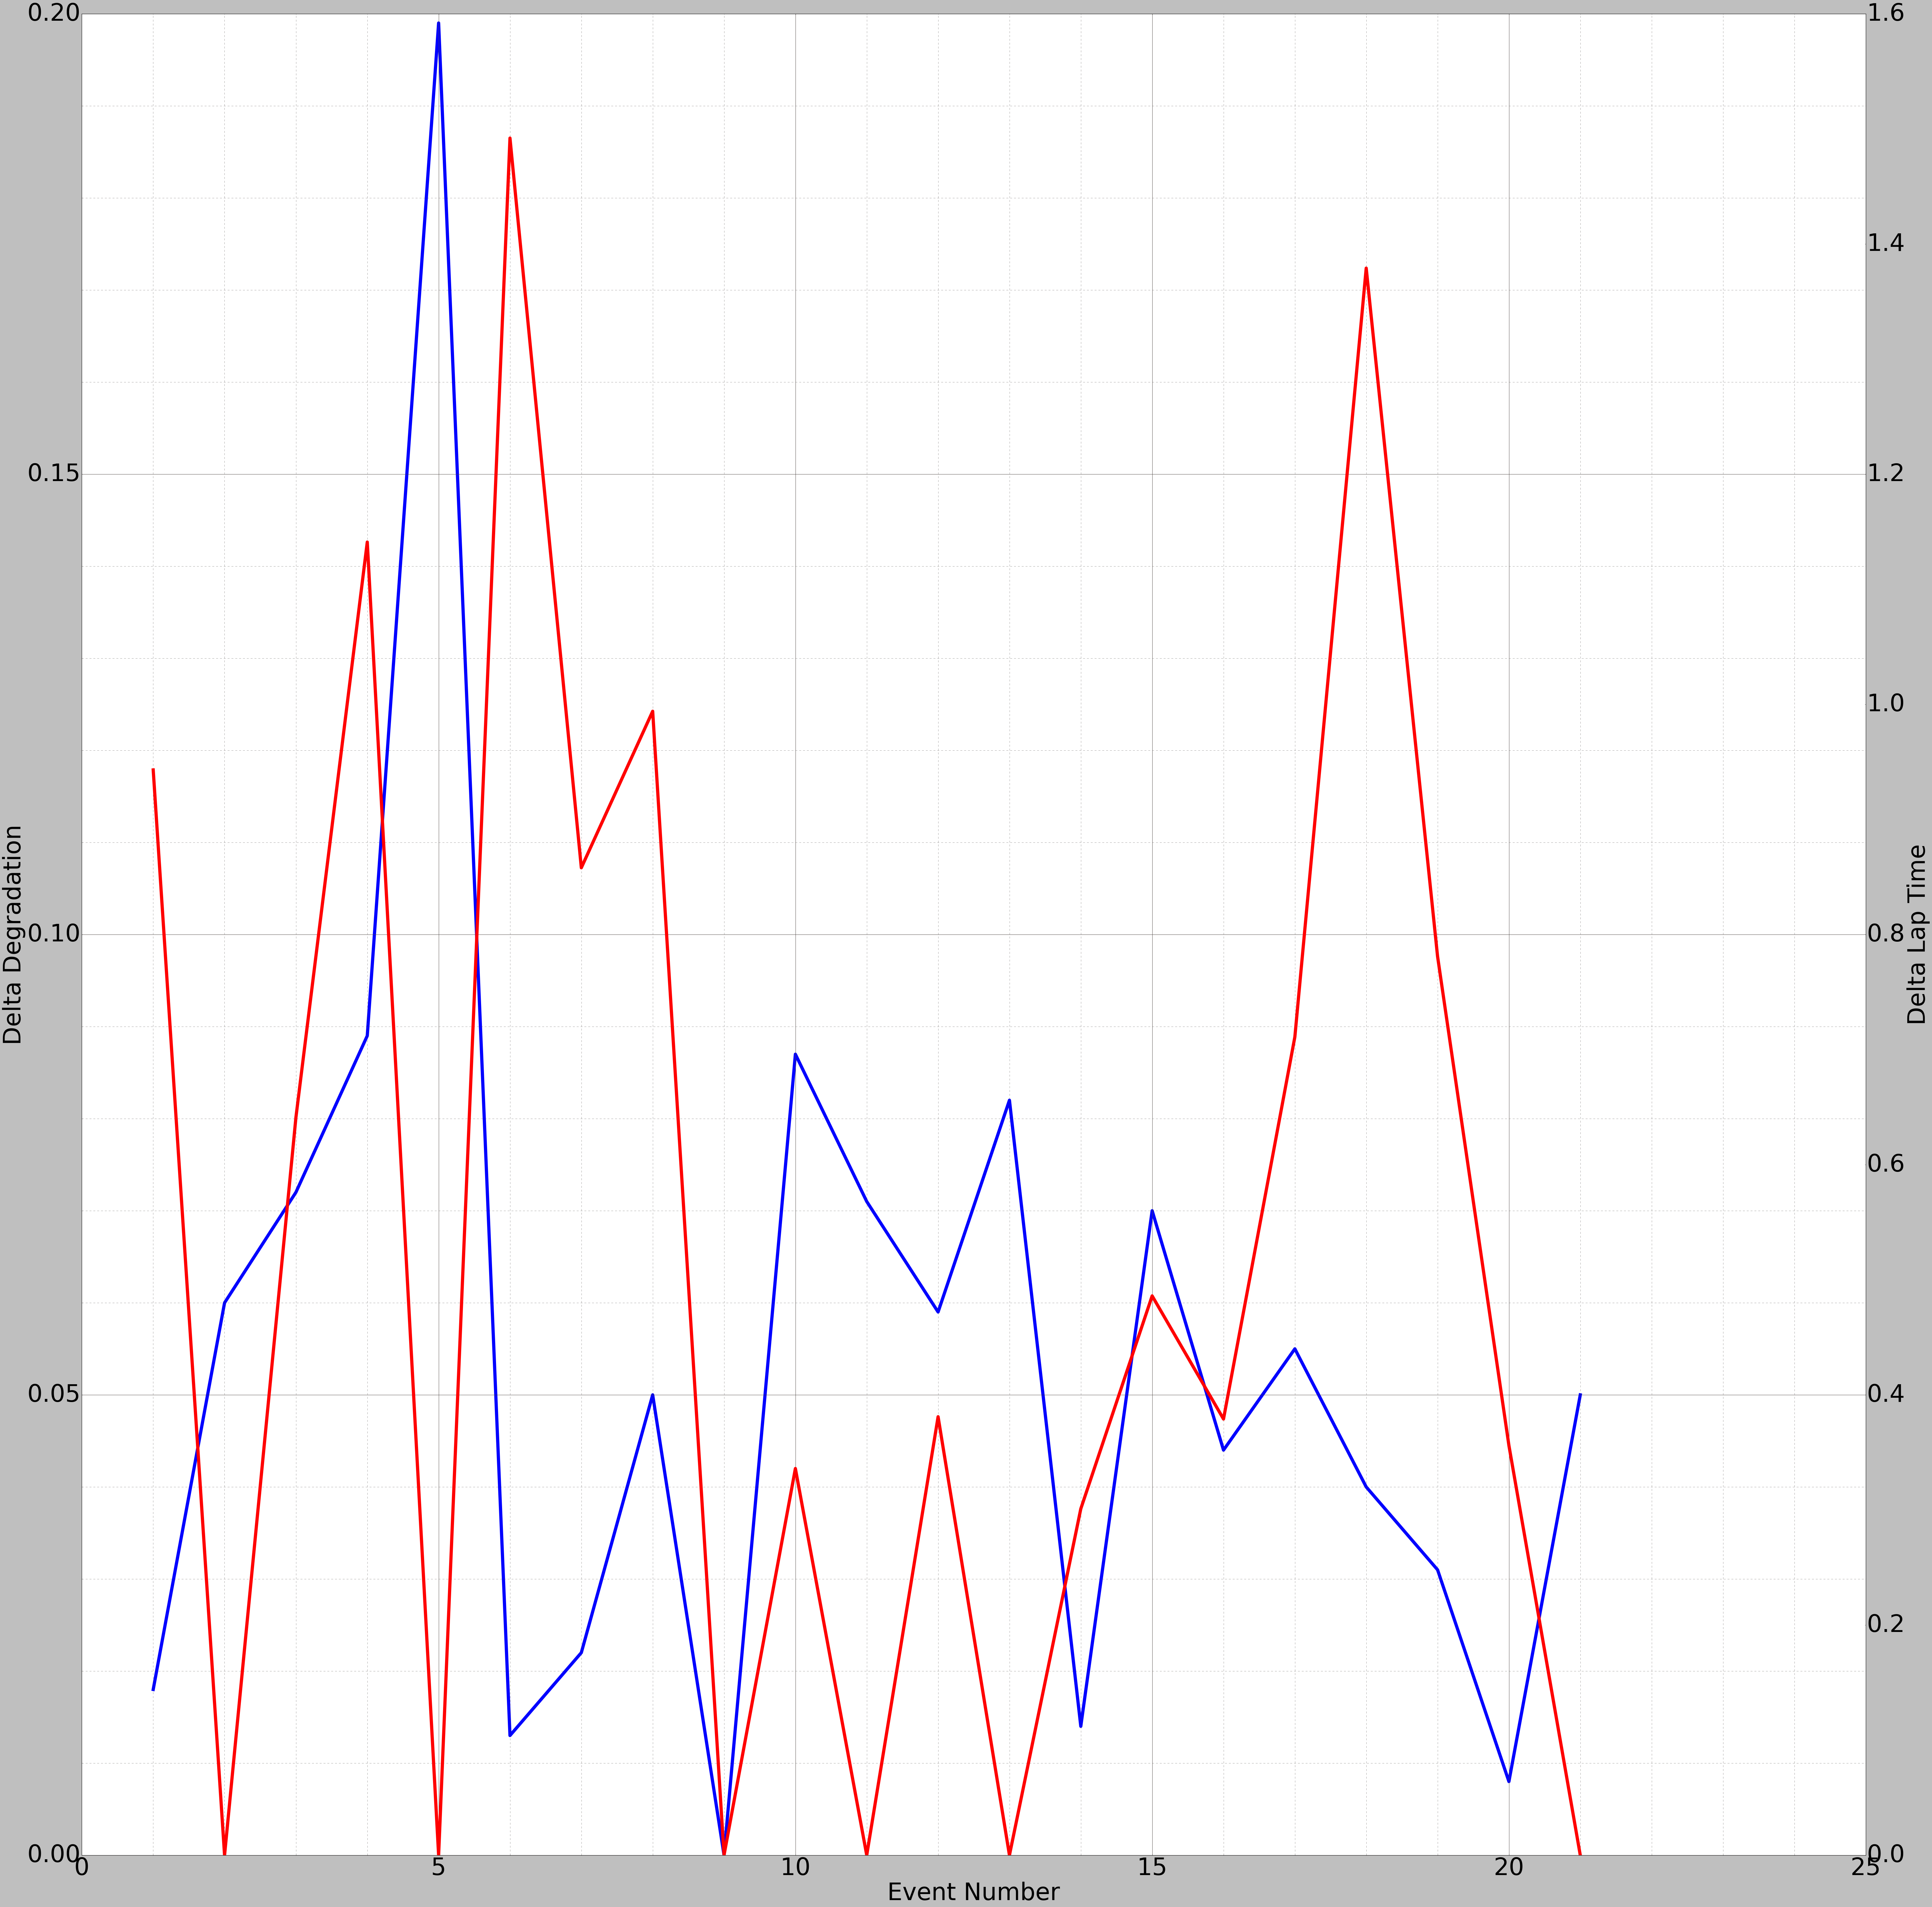

In [13]:
year = 2018
file_name = f'{year} Season.xlsx'

laps = pd.read_excel(file_name, sheet_name='Degradation Difference')

groupedTeams = groupLaps(laps, 'Team')

for team, team_df in groupedTeams:
    # Define the path for saving the figures
    save_path = os.path.join("F:", f"{team} {year}.png")

    # Define figure settings
    plt.style.use('classic')
    fig, ax1 = plt.subplots(figsize=(100, 100))
    ax1.set_facecolor('white')
    ax1.tick_params(axis='both', labelsize=75, colors='black')
    ax1.set_xlabel('Event Number', fontsize=75, color='black')
    ax1.set_ylabel('Delta Degradation', fontsize=75, color='black')

    # Plot the first graph
    ax1.plot(team_df['Event Number'], team_df['Delta Degradation'], linewidth=10, color='blue')

    # Create a second y-axis
    ax2 = ax1.twinx()

    # Set the y-axis label and tick parameters
    ax2.set_ylabel('Delta Lap Time', fontsize=75, color='black')
    ax2.tick_params(axis='y', labelsize=75, colors='black')

    # Plot the second graph
    ax2.plot(team_df['Event Number'], team_df['Delta Lap Time'], linewidth=10, color='red')


    # Save the figure
    fig.savefig(save_path)
    plt.close()
    print(team)

In [58]:
laps = pd.read_pickle('2021 Season//Azerbaijan Grand Prix Adjusted.pkl')
laps.to_excel('2021 Season//Azerbaijan GP Test.xlsx')

In [7]:
year = 2022
file_name = f'{year} Season.xlsx'

laps = pd.read_excel(file_name, sheet_name='Degradation Difference')

groupedTeams = groupLaps(laps, 'Team')

for team, team_df in groupedTeams:
    # Define the path for saving the figures
    save_path = os.path.join("F:", f"{team} {year}.png")

    # Define figure settings
    plt.style.use('classic')
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(100, 100))
    fig.set_facecolor('white')

    # Plot the first graph in the first subplot
    ax1.plot(team_df['Event Number'], team_df['Delta Degradation'], linewidth=10, color='blue')
    ax1.set_xlabel('Event Number', fontsize=75, color='black')
    ax1.set_ylabel('Delta Degradation', fontsize=75, color='black')
    ax1.tick_params(axis='both', labelsize=75, colors='black')

    # Plot the second graph in the second subplot
    ax2.plot(team_df['Event Number'], team_df['Delta Lap Time'], linewidth=10, color='red')
    ax2.set_xlabel('Event Number', fontsize=75, color='black')
    ax2.set_ylabel('Delta Lap Time', fontsize=75, color='black')
    ax2.tick_params(axis='both', labelsize=75, colors='black')

    # Save the figure
    fig.savefig(save_path)
    plt.close()
    print(team)


Alfa Romeo
AlphaTauri
Alpine
Aston Martin
Ferrari
Haas F1 Team
McLaren
Mercedes
Red Bull Racing
Williams


In [15]:
for year in range(2018,2023):
    event_list = ff1.get_event_schedule(year, include_testing=False)['EventName'].to_list()
    print(len(event_list))

21
21
17
22
22


In [7]:
#df = pd.DataFrame(columns=['Team', 'Year', 'Slope', 'Intercept'])
year = 2022
file_name = f'{year} Season.xlsx'


laps = pd.read_excel(file_name, sheet_name='Filtered Full Season')
laps = laps[(laps['Linear Slope'] > 0) & (laps['Standard Error'] < 1)]

groupedTeams = groupLaps(laps, 'Team')

for team, team_df in groupedTeams:
    # Define the path for saving the figures
    save_path = os.path.join("F:", f"{team} {year}.png")

    slope, intercept, r_value, p_value, std_err = linregress(team_df['Linear Slope'], team_df['Average Lap Time'])
    df.loc[number] = [team, year, slope, intercept]
    number += 1

    # Define figure settings
    plt.style.use('classic')
    fig, ax = plt.subplots(figsize=(100, 100))
    fig.set_facecolor('white')
    ax.set_xlabel('Average Degradation', fontsize=75, color='black')
    ax.set_ylabel('Average Lap Time', fontsize=75, color='black')
    ax.set_xlim([0,1])
    ax.tick_params(axis='both', labelsize=75, colors='black')

    # Create a scatter plot of 'Average Degradation' against 'Average Lap Time'
    ax.scatter(np.array(team_df['Linear Slope']), np.array(team_df['Average Lap Time']), s=2000, marker='x')

    # Save the figure
    fig.savefig(save_path)
    plt.close()
    print(team)
df.to_excel('2018-2022.xlsx')

Alfa Romeo
AlphaTauri
Alpine
Aston Martin
Ferrari
Haas F1 Team
McLaren
Mercedes
Red Bull Racing
Williams


In [12]:
laps

,Compound,Linear Slope,Poly Slope,Intercept,R Value,Standard Error,No of Laps,Laps Till End,Team,Driver,Event,Stint,Average Lap Time,Average Ahead,Average Behind,Safety Start,Safety End
0,MEDIUM,-4.572558,2.727616,182.130323,-0.677378,2.482906,6,33,AlphaTauri,TSU,Saudi Arabian Grand Prix,3,92.965451,-0.584000,0.713500,True,True
1,HARD,-2.609312,1.126344,146.267034,-0.538905,1.824023,7,33,Alfa Romeo Racing,RAI,Saudi Arabian Grand Prix,3,93.335284,-0.721857,0.944857,True,False
2,SOFT,-0.561261,0.907423,97.848471,-0.363036,0.720271,6,40,Haas F1 Team,MSC,Emilia Romagna Grand Prix,3,84.287103,-13.283667,36.933833,False,True
3,SOFT,0.718163,-0.664998,58.563229,0.696887,0.522605,4,4,Alpine,ALO,Saudi Arabian Grand Prix,5,93.055141,-23.098500,5.279000,False,False
4,MEDIUM,0.703253,0.660803,64.172127,0.743616,0.447114,4,69,Mercedes,BOT,São Paulo Grand Prix,1,66.633511,-1.709500,1.941000,False,True
5,SOFT,0.946233,-0.466030,7.417679,0.906500,0.311630,4,3,Mercedes,BOT,Dutch Grand Prix,3,74.045961,-41.791250,29.393667,False,False
6,MEDIUM,-0.192138,0.303485,68.734489,-0.444725,0.273623,4,69,Aston Martin,STR,São Paulo Grand Prix,1,68.062006,-1.569750,1.047500,False,True
7,MEDIUM,-0.184535,0.406622,68.243903,-0.441993,0.264819,4,69,Alpine,ALO,São Paulo Grand Prix,1,67.598032,-1.250250,1.569750,False,True
8,SOFT,-1.182846,0.388136,112.644426,-0.956761,0.254281,4,38,Haas F1 Team,MAZ,Emilia Romagna Grand Prix,3,81.299011,-42.719750,NaN,False,True
9,MEDIUM,-1.255277,0.339244,112.579471,-0.943714,0.254012,5,39,Aston Martin,VET,Emilia Romagna Grand Prix,4,80.444734,-33.958400,14.485800,False,True


In [23]:
from scipy.spatial.distance import mahalanobis
year = 2022
laps = pd.read_excel(f'{year} Season.xlsx', sheet_name='Filtered Full Season')
df = pd.DataFrame(columns=['Event', 'R Squared', 'No of Data Points', 'P Value'])

laps = laps[laps['Linear Slope'] > 0]

groupedLaps = groupLaps(laps, 'Event')

for event, event_df in groupedLaps:

    len_data = len(event_df)

    subset = event_df[['Linear Slope', 'Average Lap Time']]
    mean = np.mean(subset, axis=0)
    cov = np.cov(subset.T)
    distances = [mahalanobis(row, mean, np.linalg.inv(cov)) for row in subset.to_numpy()]

    subset['Distances'] = np.array(distances)
    subset = subset[subset['Distances'] < 2]

    slope, intercept, r_value, p_value, std_err = linregress(subset['Linear Slope'], subset['Average Lap Time'])
    df.loc[number] = [event, r_value, len_data, p_value]
    number += 1

with pd.ExcelWriter('R value.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    df.to_excel(writer, sheet_name=f'{year}', index=False)

C:\Users\benme\AppData\Local\Temp\ipykernel_16956\3866705039.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Distances'] = np.array(distances)
C:\Users\benme\AppData\Local\Temp\ipykernel_16956\3866705039.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Distances'] = np.array(distances)
C:\Users\benme\AppData\Local\Temp\ipykernel_16956\3866705039.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [17]:
events_dict = {}

In [24]:
year = 2022
race = 'Australian'

C:\Users\benme\AppData\Local\Temp\ipykernel_16956\311095109.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Distances'] = np.array(distances)


Original R-Value -0.3209526127195693, New R-Value -0.7411831010211408, New P-Value 8.073775475645487e-07
{'2022 French Grand Prix': [-0.259, 0.1169], '2022 Australian Grand Prix': [-0.741, 0.0]}


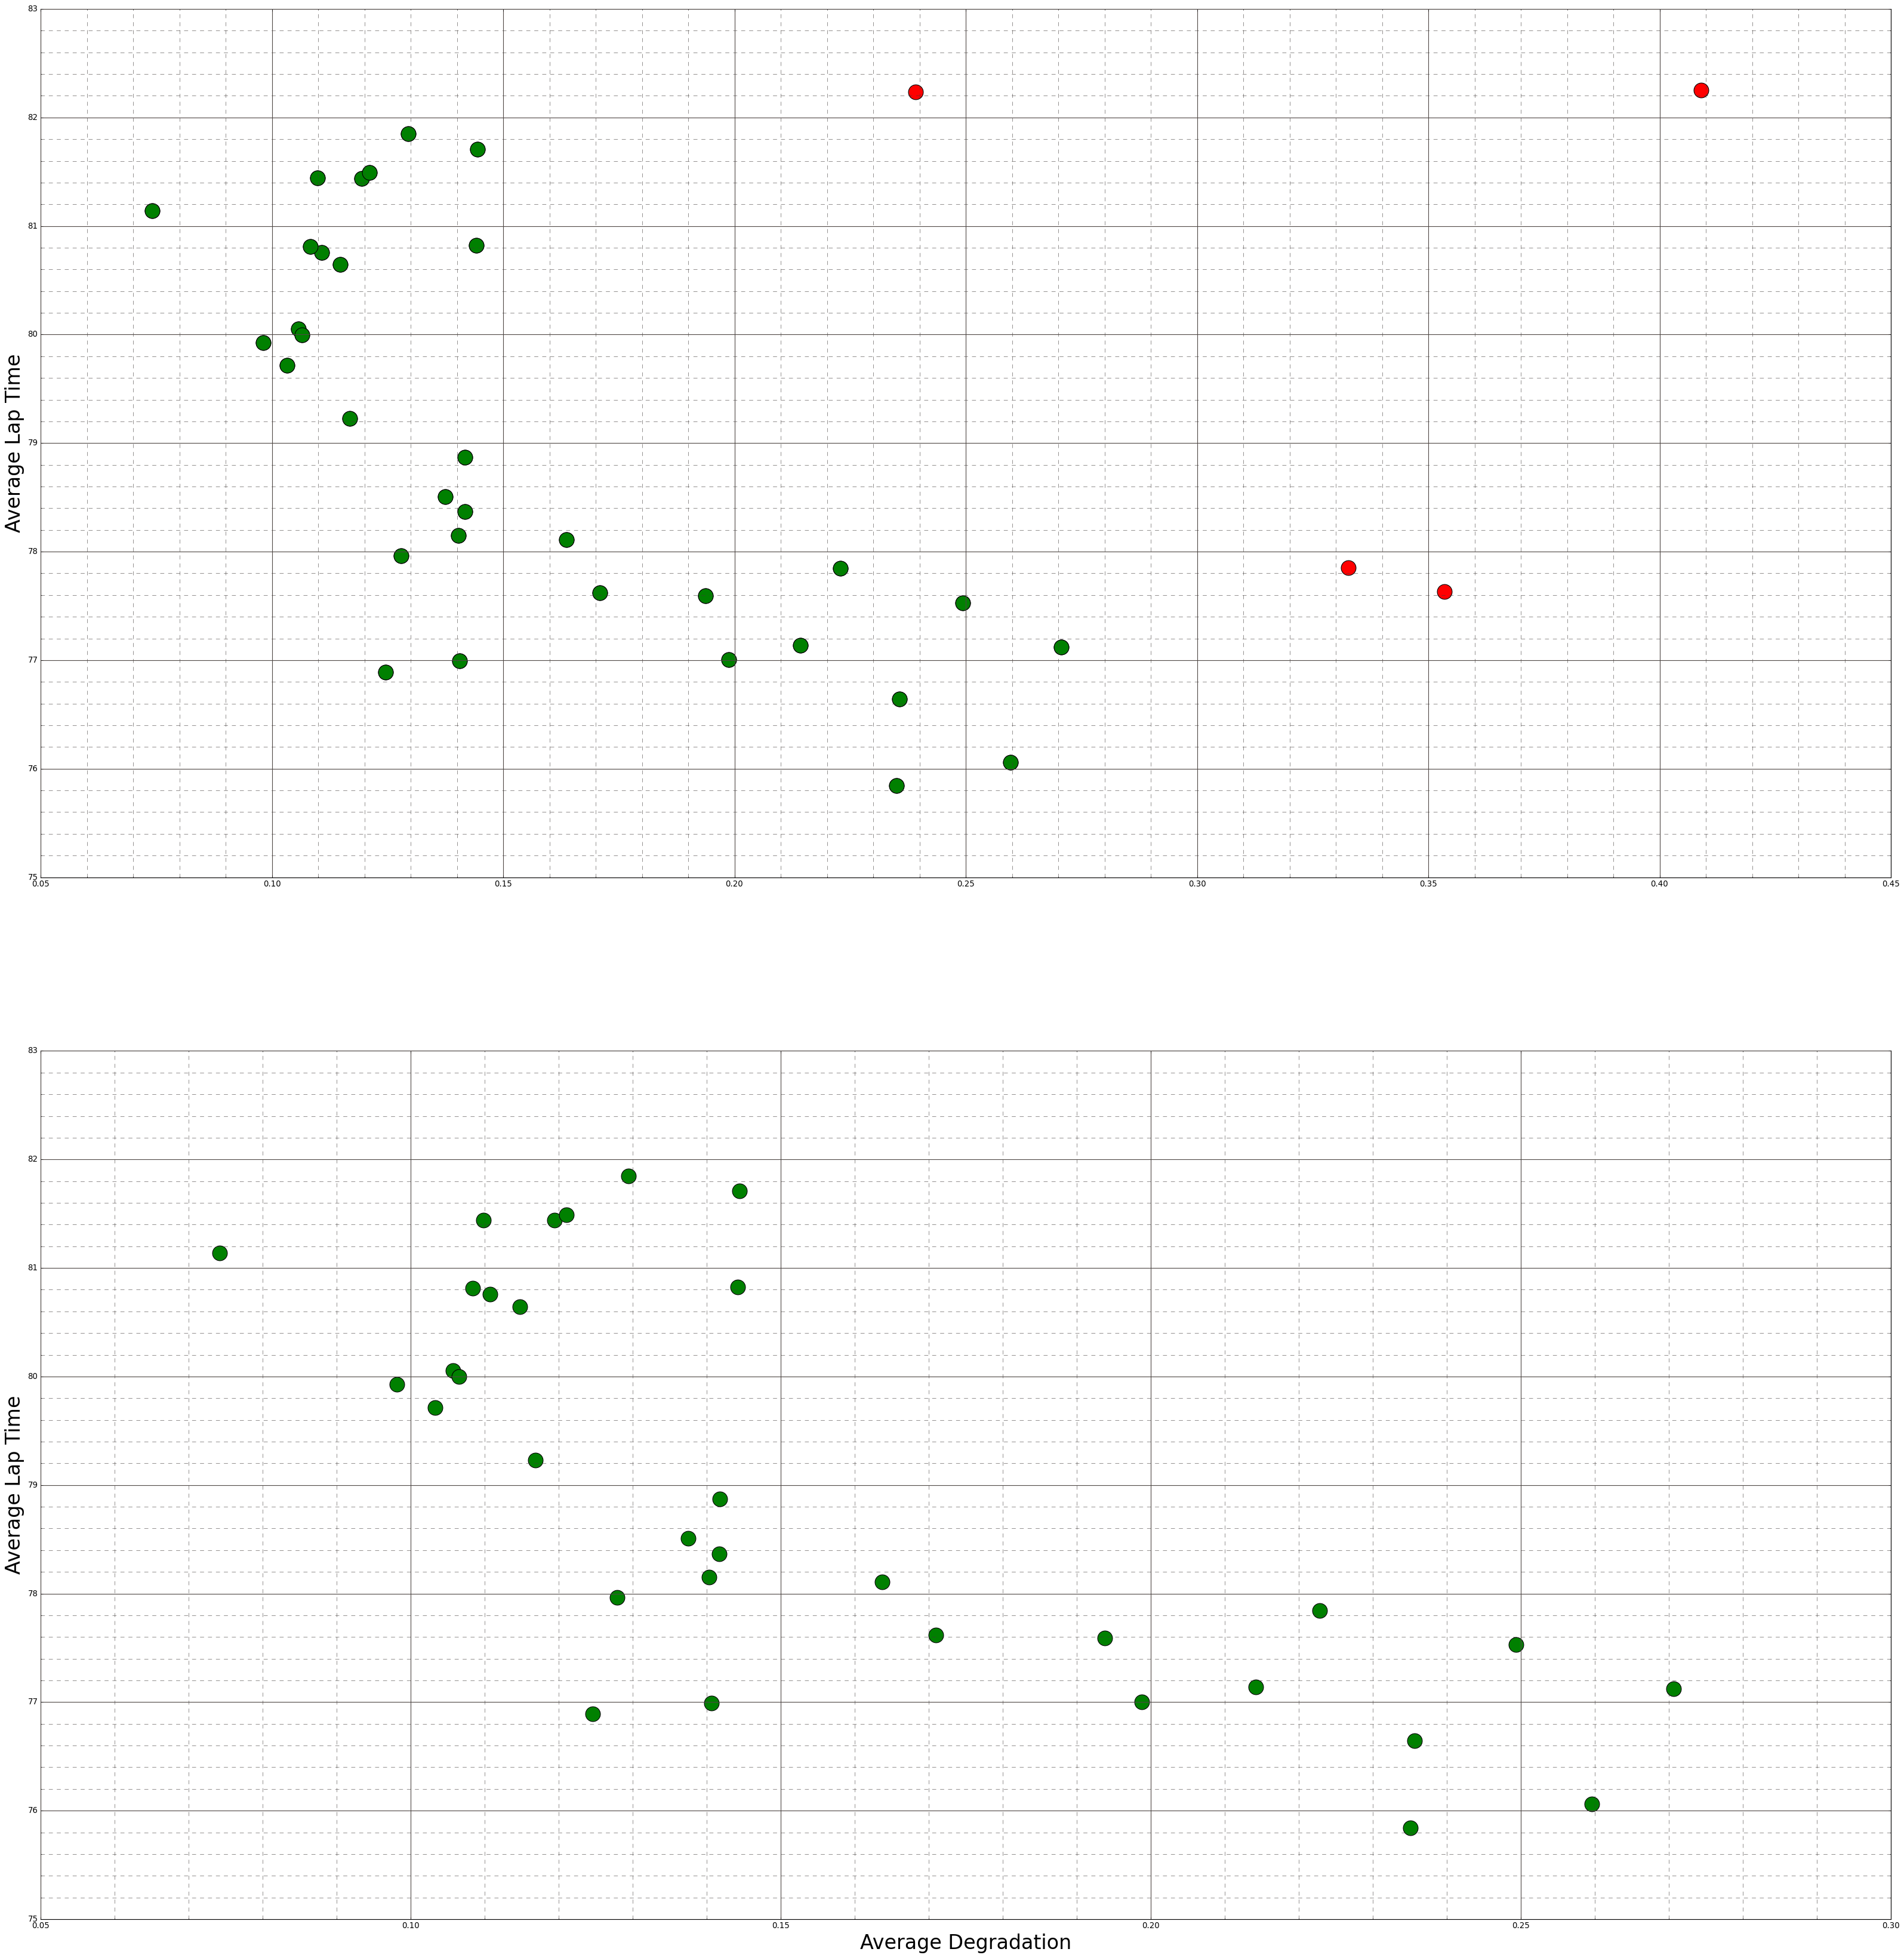

In [25]:
laps = pd.read_excel(f'{year} Season.xlsx', sheet_name=f'{race} Grand Prix')
laps = laps[laps['Linear Slope'] > 0]

from scipy.spatial.distance import mahalanobis

subset = laps[['Linear Slope', 'Average Lap Time']]
mean = np.mean(subset, axis=0)
cov = np.cov(subset.T)
distances = [mahalanobis(row, mean, np.linalg.inv(cov)) for row in subset.to_numpy()]

subset['Distances'] = np.array(distances)
subset = subset[subset['Distances'] < 2]

plt.style.use('classic')
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(50,50))
fig.set_facecolor('white')
ax2.set_xlabel('Average Degradation', fontsize=30, color='black')
ax1.set_ylabel('Average Lap Time', fontsize=30, color='black')
ax2.set_ylabel('Average Lap Time', fontsize=30, color='black')

ax1.scatter(laps['Linear Slope'], laps['Average Lap Time'],s=500, c='red')
ax1.scatter(subset['Linear Slope'], subset['Average Lap Time'],s=500, c='green')

ax2.scatter(subset['Linear Slope'], subset['Average Lap Time'],s=500, c='green')

result = linregress(laps['Linear Slope'], laps['Average Lap Time'])
updated_result = linregress(subset['Linear Slope'], subset['Average Lap Time'])
print(f'Original R-Value {result.rvalue}, New R-Value {updated_result.rvalue}, New P-Value {updated_result.pvalue}')
events_dict[f'{year} {race} Grand Prix'] = [round(updated_result.rvalue, 3), round(updated_result.pvalue, 4)]
print(events_dict)

In [90]:
2